In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import Uniform
import os

from google.colab import drive
drive.mount('/content/drive')

# --- 0. Configuration & Device ---
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

torch.set_default_dtype(torch.float64)

# Determine the device to run the computations on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


In [2]:
# --- 1. The Neural Network (Outputs Stresses Directly) ---
class PINN(nn.Module):
    def __init__(self, layers, r_domain, z_domain):
        super().__init__()
        self.activation = nn.SiLU()
        
        # Normalization bounds (important for convergence)
        self.lb = torch.tensor([     0.0,      0.0]).to(device)
        self.ub = torch.tensor([r_domain, z_domain]).to(device)
        
        self.layers = nn.ModuleList()
        # Input: 2 (r, z) -> Hidden Layers
        self.layers.append(nn.Linear(2, layers[0]))

        # Hidden layers
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        
        # Output: 2 displacements [u_r, w]
        self.layers.append(nn.Linear(layers[-1], 2))
        
        # Esta línea no se necesita (ver más abajo)
        #self._initialize_weights()


    # Si miramos https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
    # podemos ver que las capas automatícamente inicializan los pesos y biases
    """def _initialize_weights(self):
        for layer in self.layers:
           if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)
                nn.init.zeros_(layer.bias)"""


    def forward(self, x):
        # x: [Nsamples, 2] with columns [r, z]

        # Normalize inputs to [-1, 1] range
        x_norm = 2.0*(x - self.lb)/(self.ub - self.lb) - 1.0
        
        # Input layer
        out = x_norm

        # Hidden layers with activation
        for layer in self.layers[:-1]:
            out = self.activation(layer(out))

        # Final layer without activation
        # Output: [Nsamples, 2] with columns [u_r, w]
        out = self.layers[-1](out)
        
        return out # returns [u_r, w]

In [3]:
def calc_deriv(f, x):
    """Compute df/dx using autograd with higher-order derivatives enabled."""
    (df_dx,) = torch.autograd.grad(f, x, 
                                grad_outputs=torch.ones_like(f), 
                                create_graph=True)

    # create_graph=True constructs a higher-order graph for the returned 
    # gradient, allowing you to differentiate this gradient later (e.g., for 
    # Hessian or higher-order derivatives).

    return df_dx


def bivariate_isotropic_normal_pdf(r, sigma=1.0):
    """
    Computes the Normal PDF explicitly.
    Args:
        x:  Input tensor (points)
        sigma: Standard deviation (scalar or tensor broadcastable to x)
    """
    return 1.0/(2*np.pi*sigma**2)*torch.exp(-0.5*(r/sigma)**2)


# --- 2. The Physics Class (Equilibrium + Compatibility) ---
class BoussinesqPINN:
    def __init__(self, network, nu, P_load, domain_r, domain_z, total_epochs, sigma_load, decay_rate):
        self.network    = network.to(device)
        self.E          = 1.0         # Young's modulus (can be set to 1 for non-dimensionalization)
        self.nu         = nu          # Poisson's ratio
        self.P_load     = P_load      # Magnitude of point load
        self.R_DOMAIN   = domain_r    # Radial domain size
        self.Z_DOMAIN   = domain_z    # Vertical domain size
        self.sigma_load = sigma_load  # Initial Gaussian stddev for load regularization
        self.decay_rate = decay_rate  # Decay rate for sigma_load
        
        # Optimizer
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=1e-3)
        
        # Scheduler for learning rate decay 
        # The initial lr is set in the optimizer and it decays to eta_min over T_max epochs
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer, T_max=total_epochs, eta_min=1e-7)
        
        # Loss History
        self.history       = []
        self.Total_loss    = []
        self.Loss_eq       = []
        self.Loss_far      = []
        self.Loss_bc_sigma = []
        self.Loss_bc_tau   = []
        self.Loss_bm       = []
        self.Loss_int      = []

    def get_stresses(self, r, z):
        """Forward pass to get stresses."""
        r.requires_grad = True                                                  # Check if we have to set zero_grad here
        z.requires_grad = True

        # 1. Get displacements from the network
        coord = torch.column_stack([r, z])
        u = self.network(coord) # u = [Nsamples, 2] with columns [u_r, w]
        u_r = u[:, [0]]
        w   = u[:, [1]]

        # 2. Compute strains
        eps_rr = calc_deriv(u_r, r)

        # Avoid division by zero at r=0
        # Use u_r/r where safe, otherwise use radial strain (limit value)
        eps_tt = torch.where(r.abs() > 1e-4, u_r/r, eps_rr)
        eps_zz = calc_deriv(w, z)
        eps_rz = calc_deriv(u_r, z) + calc_deriv(w, r)

        # 3. Compute stresses (Hooke's Law for isotropic materials)
        E  = self.E
        nu = self.nu

        coeff = E/((1 + nu)*(1 - 2*nu))
        G     = E/(2*(1 + nu))

        s_rr = coeff * ((1 - nu)*eps_rr + nu*(eps_tt + eps_zz))
        s_tt = coeff * ((1 - nu)*eps_tt + nu*(eps_rr + eps_zz))
        s_zz = coeff * ((1 - nu)*eps_zz + nu*(eps_rr + eps_tt))
        t_rz = G*eps_rz

        return s_zz, s_rr, s_tt, t_rz                                           # TO DO TO DO TO DO TO DO --- Swap order for convenience


    def compute_residuals(self, r, z):
        """Computes Equilibrium and Compatibility (Beltrami-Michell) residuals."""
        r.requires_grad = True                                                  # Check if we have to set zero_grad here
        z.requires_grad = True

        s_zz, s_rr, s_tt, t_rz = self.get_stresses(r, z)

        # First Derivatives
        dsrr_dr = calc_deriv(s_rr, r)
        dsrr_dz = calc_deriv(s_rr, z)

        dstt_dr = calc_deriv(s_tt, r)
        dstt_dz = calc_deriv(s_tt, z)

        dszz_dr = calc_deriv(s_zz, r)
        dszz_dz = calc_deriv(s_zz, z)

        dtrz_dr = calc_deriv(t_rz, r)
        dtrz_dz = calc_deriv(t_rz, z)

        '''
        # --- Equilibrium Equations (Axisymmetric) ---
        # Radial Equilibrium Term: lim_{r-> 0} (s_rr - s_tt)/r = 0
        # Limit is 0 because s_rr = s_tt at r=0
        term1 = torch.where(r.abs() > 1e-4, (s_rr - s_tt)/r, torch.zeros_like(r))

        # 2. Vertical Equilibrium Term:  lim_{r-> 0} t_rz/r = dtrz/dr
        term2 = torch.where(r.abs() > 1e-4, t_rz/r, dtrz_dr)

        # 1. Radial Equilibrium
        eq1 = dsrr_dr + dtrz_dz + term1 # + b_r == 0
        # 2. Vertical Equilibrium
        eq2 = dtrz_dr + dszz_dz + term2 # + b_z == 0
        '''
        # --- Equilibrium Equations (Axisymmetric) ---
        # Multiply by r to avoid singularities at r=0        
        # 1. Radial Equilibrium
        eq1 = r*dsrr_dr + r*dtrz_dz + (s_rr - s_tt) # + r*b_r == 0

        # 2. Vertical Equilibrium
        eq2 = r*dtrz_dr + r*dszz_dz + t_rz          # + r*b_z == 0

        # --- B. Compatibility (Beltrami-Michell) ---
        Theta = s_rr + s_tt + s_zz
        k = 1.0 / (1.0 + self.nu)

        # Helper for Laplacian: d2f/dr2 + 1/r df/dr + d2f/dz2
        def laplacian_cyl(val, d_dr, d_dz):
            d2_dr2 = calc_deriv(d_dr, r)
            d2_dz2 = calc_deriv(d_dz, z)
            return d2_dr2 + (1.0/r + 1e-6)*d_dr + d2_dz2

        lap_s_zz = laplacian_cyl(s_zz, dszz_dr, dszz_dz)
        #lap_s_rr = laplacian_cyl(s_rr, dsrr_dr, dsrr_dz)
        #lap_s_tt = laplacian_cyl(s_tt, dstt_dr, dstt_dz)
        #lap_t_rz = laplacian_cyl(t_rz, dtrz_dr, dtrz_dz)

        # Derivatives of Theta
        #dTh_dr    = calc_deriv(Theta, r)
        dTh_dz    = calc_deriv(Theta, z)

        #d2Th_dr2  = calc_deriv(dTh_dr, r)
        d2Th_dz2  = calc_deriv(dTh_dz, z)
        #d2Th_drdz = calc_deriv(dTh_dr, z)

        # BM Equations
        bm1 = lap_s_zz + k * d2Th_dz2
        #bm2 = lap_s_rr - (2.0/r**2)*(s_rr - s_tt) + k * d2Th_dr2
        #bm3 = lap_s_tt + (2.0/r**2)*(s_rr - s_tt) + k * (1.0/r) * dTh_dr
        #bm4 = lap_t_rz - (1.0/r**2)*t_rz + k * d2Th_drdz

        return eq1, eq2, bm1 #, bm2, bm3, bm4

    def sample_points(self, n_pde, n_bc):
        """
        Resample all collocation points for each training step.
        n_pde: Number of PDE points
        n_bc:  Number of BC points

        Returns: pde_pts, surface_pts, far_field_pts
        """
        MIN_r = 0.1  # Minimum r to avoid singularity at r=0

        # 1. PDE Points (with bias near load)
        N_LOG     = int(0.7*n_pde) 
        N_UNIFORM = n_pde - N_LOG

        N_SURFACE  = int(0.4*n_bc)
        N_FARFIELD = int(0.6*n_bc)

        # 1. Define log bounds
        log_min = np.log(MIN_r)
        log_max = np.log(self.R_DOMAIN)

        # 2. Sample uniformly in log space
        r_log     = Uniform(log_min, log_max).sample((N_LOG, 1))
        r_pde_reg = torch.exp(r_log)     # r values heavily biased towards MIN_r

        # z can remain Uniform or also be clustered near 0 if needed
        z_pde_reg = Uniform(0.0, self.Z_DOMAIN).sample((N_LOG, 1))

        # Standard uniform sampling for the rest
        r_pde_unif = Uniform(MIN_r, self.R_DOMAIN).sample((N_UNIFORM, 1))
        z_pde_unif = Uniform(0.0,   self.Z_DOMAIN).sample((N_UNIFORM, 1))

        # r_pde   = torch.row_stack([r_pde_reg, r_pde_unif])
        # z_pde   = torch.row_stack([z_pde_reg, z_pde_unif])
        # pde_pts = torch.column_stack([r_pde, z_pde])

        pde_pts = torch.cat([
            torch.cat((r_pde_reg,  z_pde_reg),  dim=1),
            torch.cat((r_pde_unif, z_pde_unif), dim=1)
        ], dim=0).to(device)

        # 2. BC Points
        # Surface
        r_surface   = Uniform(MIN_r, self.R_DOMAIN).sample((N_SURFACE, 1))
        surface_pts = torch.column_stack([r_surface, torch.zeros_like(r_surface)]).to(device)

        # Far-field
        r_far_vert  = torch.full((N_FARFIELD, 1), self.R_DOMAIN)
        z_far_vert  = Uniform(0.0, self.Z_DOMAIN).sample((N_FARFIELD, 1))

        r_far_horiz = Uniform(MIN_r, self.R_DOMAIN).sample((N_FARFIELD, 1))
        z_far_horiz = torch.full((N_FARFIELD, 1), self.Z_DOMAIN)

        far_field_pts = torch.row_stack([
            torch.column_stack([r_far_vert,  z_far_vert ]),
            torch.column_stack([r_far_horiz, z_far_horiz])
        ]).to(device)
        
        # Puntos para la Integral (Base)
        r_int = torch.linspace(1e-4, self.R_DOMAIN, 300).view(-1, 1).to(device)
        z_int = torch.full_like(r_int, self.Z_DOMAIN)
        integral_pts = torch.cat([r_int, z_int], 1)

        return pde_pts, surface_pts, far_field_pts, integral_pts

    def loss_function(self, pde_pts, surf_pts, far_pts, int_pts):
        # A. PDE Residuals
        r_pde, z_pde = pde_pts[:, [0]], pde_pts[:, [1]]
        eq1, eq2, bm1 = self.compute_residuals(r_pde, z_pde)

        loss_eq = torch.mean(eq1**2) + torch.mean(eq2**2)
        loss_bm = torch.mean(bm1**2) # + torch.mean(bm2**2) + torch.mean(bm3**2) + torch.mean(bm4**2)

        # B. Surface Boundary (Load)
        r_s, z_s = surf_pts[:, [0]], surf_pts[:, [1]]
        s_zz_s, _, _, t_rz_s = self.get_stresses(r_s, z_s)
        
        # Load Approximation (Gaussian to approximate point load P)
        load_profile = -self. P_load*bivariate_isotropic_normal_pdf(r_s, self.sigma_load)

        loss_bc_sigma = torch.mean((s_zz_s - load_profile)**2)
        loss_bc_tau   = torch.mean(t_rz_s**2) # Shear is 0

        # C. Far Field (Zero Stress)
        r_f, z_f = far_pts[:, [0]], far_pts[:, [1]]
        s_zz_f, s_rr_f, s_tt_f, t_rz_f = self.get_stresses(r_f, z_f)
        loss_far = torch.mean(s_rr_f**2 + s_tt_f**2 + t_rz_f**2)

        loss_bc_total = loss_bc_sigma + loss_bc_tau + loss_far

        #int_0_R = lambda r : 2*np.pi*r*sz(r, Z_DOMAIN)
        #load_Z_DOMAIN = torch.trapz(int_0_R(r_f), r_f.squeeze())
        #load_Z_DOMAIN = torch.trapz(int_0_R(r_f), r_f.squeeze())
        #loss_esf_z = torch.mean((load_Z_DOMAIN - P - load)**2)

        #D. Pérdida integral de carga (opcional)
        r_i = int_pts[:, [0]]
        z_i = int_pts[:, [1]]
        s_zz_i, _, _, _ = self.get_stresses(r_i, z_i)

        # Integral de Carga
        s_zz_i, _, _, _ = self.get_stresses(r_i, z_i)
        force = torch.trapezoid(2 * np.pi * r_i.squeeze() * s_zz_i.squeeze(), r_i.squeeze())
        loss_int = (force + self.P_load)**2


        #Adaptive Loss Weights (can be tuned or made dynamic)
        with torch.no_grad():
            w_bc = loss_eq.item() / (loss_bc_total.item() + 1e-8) #Check magnitude of losses for adaptive weighting if needed
            w_bc = min(max(w_bc, 10.0), 100.0) #Clip w_bc to reasonable range

            w_int = loss_eq.item() / (loss_int.item() + 1e-8)
            w_int = min(max(w_int, 1.0), 10.0)

            w_bm = loss_eq.item() / (loss_bm.item() + 1e-8)
            w_bm = min(max(w_bm, 0.1), 10.0)


        total_loss = loss_eq + w_bm*loss_bm + w_bc*loss_bc_total + w_int*loss_int

        return total_loss, loss_eq, loss_far, loss_bc_sigma, loss_bc_tau, loss_bm, loss_int
    

    def train(self, epochs, n_pde, n_bc):

        print("--- Starting Training (Gaussian regularized load, Resampling) ---")

        print(f'{"Epoch":^9} | '
              f'{"Loss":^10} | '
              f'{"EQ":^10} | '
              f'{"Far":^10} | '
              f'{"BC Sigma":^12} | '
              f'{"BC Tau":^12} | '
              f'{"BM":^12} | '
              f'{"Int":^12} | '
              f'{"LR":^12} | '
              f'{"Sigma Load":^12}')
        print(150*"-")

        pde_pts, surf_pts, far_pts, int_pts = self.sample_points(n_pde, n_bc)
        
        for epoch in range(epochs):
            self.network.train()
            self.optimizer.zero_grad()
            
            # Resample rarely to keep training stable
            if epoch % 1000 == 0 and epoch > 0:
                pde_pts, surf_pts, far_pts, int_pts = self.sample_points(n_pde, n_bc)
            
            if self.sigma_load > 0.2:
                self.sigma_load -= self.decay_rate
                       
            total_loss, loss_eq, loss_far, loss_bc_sigma, loss_bc_tau, loss_bm, loss_int = self.loss_function(pde_pts, surf_pts, far_pts, int_pts)

            total_loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            
            self.Total_loss.append(total_loss.item())
            self.Loss_eq.append(loss_eq.item())
            self.Loss_far.append(loss_far.item())
            self.Loss_bc_sigma.append(loss_bc_sigma.item())
            self.Loss_bc_tau.append(loss_bc_tau.item())
            self.Loss_bm.append(loss_bm.item())
            self.Loss_int.append(loss_int.item())
           
            if epoch % 500 == 0:
                print(f"{epoch+1:4d}/{epochs:4d} | "
                      f"{total_loss.item():10.4e} | "
                      f"{loss_eq.item():10.4e} | "
                      f"{loss_far.item():10.4e} | "
                      f"{loss_bc_sigma.item():12.4e} | "
                      f"{loss_bc_tau.item():12.4e} | "
                      f"{loss_bm.item():12.4e} | "
                      f"{loss_int.item():12.4e} | "
                      f"{self.optimizer.param_groups[0]['lr']:10.4e} | "
                      f"{self.sigma_load:12.4e} ")
                
                if total_loss.item() < 1e-8:
                    print("Early stopping criterion met.")
                    break

In [4]:
def refine_with_lbfgs(solver, n_pde=5000, n_bc=1000, max_iter=2000):
    """
    External fuctuon to refine the model using L-BFGS after training with Adam.
    Does not modify the original class, just optimizes the network parameters."""
 
    print("\n--- Starting L-BFGS Refinement (Second Stage) ---")
    
    # Optimizador L-BFGS (Converge muy rápido cuando ya estás cerca)
    optimizer_lbfgs = torch.optim.LBFGS(solver.network.parameters(), 
                                        lr=1.0, 
                                        history_size=50, 
                                        max_iter=max_iter, 
                                        line_search_fn="strong_wolfe")

    # Muestreamos puntos fijos para esta etapa de refinamiento
    pde_pts, surf_pts, far_pts, int_pts = solver.sample_points(n_pde, n_bc)

    # Función de cierre (closure) que L-BFGS necesita
    def closure():
        optimizer_lbfgs.zero_grad()
        loss, loss_eq, loss_far, loss_bc_sigma, loss_bc_tau, loss_bm, loss_int = solver.loss_function(pde_pts, surf_pts, far_pts, int_pts)
        loss.backward()
        return loss

    # Ejecutar el optimizador
    loss_pre = closure()
    print(f"Loss before L-BFGS: {loss_pre.item():.5e}")
    
    optimizer_lbfgs.step(closure)
    
    loss_post = closure()
    print(f"Loss after L-BFGS: {loss_post.item():.5e}")
    print("--- Refinement Completed ---")

print("Tools loaded correctly.")

Tools loaded correctly.


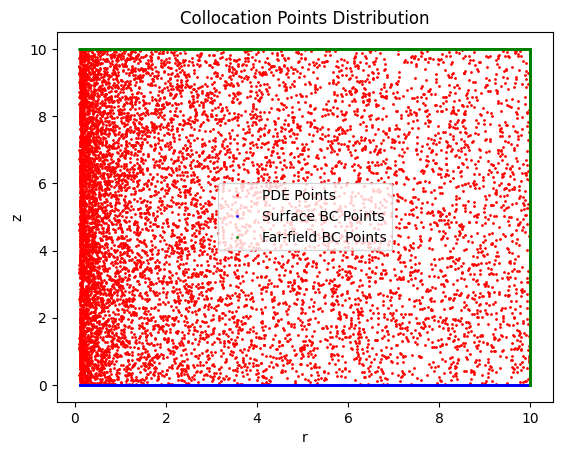

In [5]:
# --- 3. Execution & Visualization ---

# Parameters
R_DOMAIN = 10.0
Z_DOMAIN = 10.0
NU = 0.3
P_LOAD = 100.0 # Load magnitude

EPOCHS = 10_000
N_PDE  = 10_000
N_BC   = 5_000

SIGMA_LOAD = 2.0
DECAY_RATE = 0.00039

# Model
net = PINN(layers=[100, 100, 100, 100, 100, 100], r_domain=R_DOMAIN, z_domain=Z_DOMAIN)
solver = BoussinesqPINN(
    network=net,
    nu=NU,
    P_load=P_LOAD,
    domain_r=R_DOMAIN,
    domain_z=Z_DOMAIN,
    total_epochs=EPOCHS,
    sigma_load=SIGMA_LOAD,
    decay_rate=DECAY_RATE
)

pde_pts, surf_pts, far_pts, int_pts = solver.sample_points(N_PDE, N_BC)

plt.figure()
plt.plot( pde_pts[:,0].cpu().numpy(),  pde_pts[:,1].cpu().numpy(), 'ro', markersize=1, label='PDE Points')
plt.plot(surf_pts[:,0].cpu().numpy(), surf_pts[:,1].cpu().numpy(), 'bo', markersize=1, label='Surface BC Points')
plt.plot( far_pts[:,0].cpu().numpy(),  far_pts[:,1].cpu().numpy(), 'go', markersize=1, label='Far-field BC Points')
plt.xlabel('r')
plt.ylabel('z')
plt.title('Collocation Points Distribution')
plt.legend()
plt.show()

In [6]:
# 1. Define the folder where you want to keep your thesis work
save_dir = '/content/drive/MyDrive/Master_Thesis_PINN'
os.makedirs(save_dir, exist_ok=True)
filename = os.path.join(save_dir, 'boussinesq_model_testing10000.pth')

print(f"Model route set to: {filename}")

# Set to True to skip training and load the saved weights
cargar_modelo_entrenado = False  # Change to True to load the model instead of training

if cargar_modelo_entrenado:
    if os.path.exists(filename):
        # 1. Instantiate the empty network architecture (Must match the trained model)
        net = PINN(layers=[100, 100, 100, 100, 100, 100], r_domain=R_DOMAIN, z_domain=Z_DOMAIN)
        
        # 2. Load the weights into the network securely
        net.load_state_dict(torch.load(filename, map_location=device, weights_only=True))
        
        # 3. Reconstruct the solver object passing the trained network
        solver = BoussinesqPINN(
            network=net,
            nu=NU,
            P_load=P_LOAD,
            domain_r=R_DOMAIN,
            domain_z=Z_DOMAIN,
            total_epochs=EPOCHS,
            sigma_load=SIGMA_LOAD,
            decay_rate=DECAY_RATE
        )
        print("Model weights successfully loaded from:", filename)
    else:
        print(f"Error: Model file not found at {filename}. Did you train and save it first?")

else:
    print("Starting new training session...")
    
    # Training call
    solver.train(epochs=EPOCHS, n_pde=N_PDE, n_bc=N_BC)
    refine_with_lbfgs(solver, n_pde=N_PDE, n_bc=N_BC)
    
    # Save ONLY the network's weights (Corrected line)
    torch.save(solver.network.state_dict(), filename)
    print("\n--- Training Complete --- Model weights saved to", filename)

Model route set to: /content/drive/MyDrive/Master_Thesis_PINN/boussinesq_model_testing10000.pth
Starting new training session...
--- Starting Training (Gaussian regularized load, Resampling) ---
  Epoch   |    Loss    |     EQ     |    Far     |   BC Sigma   |    BC Tau    |      BM      |     Int      |      LR      |  Sigma Load 
------------------------------------------------------------------------------------------------------------------------------------------------------
   1/10000 | 1.0192e+04 | 7.3874e-03 | 6.3410e-04 |   2.7757e+00 |   4.6496e-09 |   4.6115e+00 |   1.0164e+04 | 1.0000e-03 |   1.9996e+00 
 501/10000 | 1.4829e+01 | 2.3274e-01 | 1.7223e-01 |   1.0800e+00 |   1.4501e-01 |   3.9094e+00 |   3.5052e-02 | 9.9382e-04 |   1.8046e+00 
1001/10000 | 5.3875e+00 | 3.9945e-01 | 1.1152e-01 |   1.3343e-01 |   8.5195e-02 |   1.2074e+00 |   1.2871e+00 | 9.7548e-04 |   1.6096e+00 
1501/10000 | 4.8214e+00 | 6.2770e-01 | 7.9560e-02 |   5.7977e-02 |   6.4026e-02 |   1.8414e+00 |  


--- Plotting Learning Curve ---


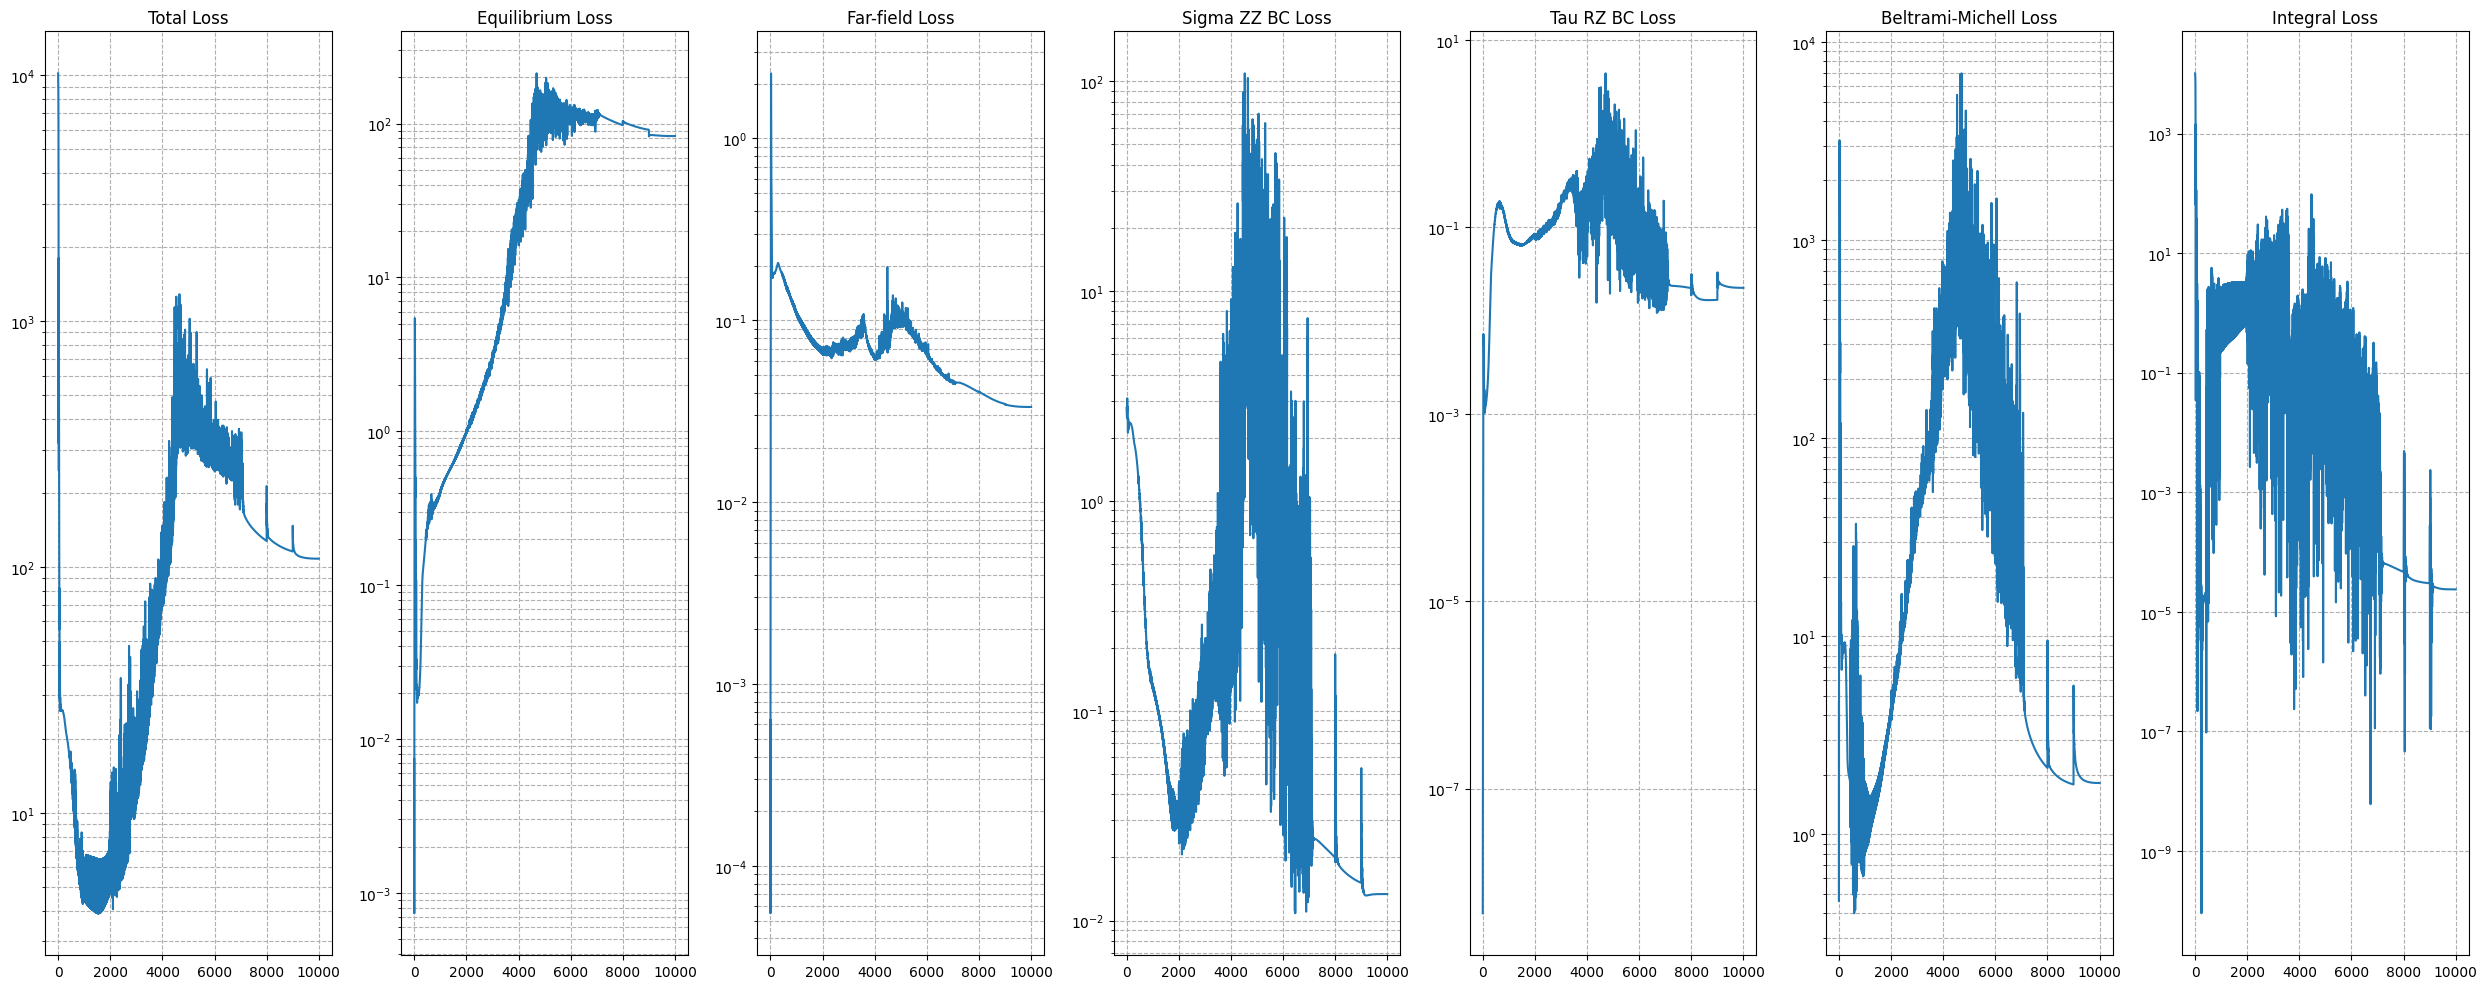

In [7]:
# Plotting lerarning curves

print("\n--- Plotting Learning Curve ---")

fig, axes = plt.subplots(1, 7, figsize=(25, 10))

# Total Loss
axes[0].plot(solver.Total_loss)
axes[0].set_title('Total Loss')
axes[0].set_yscale('log')
axes[0].grid(True, which="both", ls="--")

# EQ Loss
axes[1].plot(solver.Loss_eq)
axes[1].set_title('Equilibrium Loss')
axes[1].set_yscale('log')
axes[1].grid(True, which="both", ls="--")

# Far-field Loss
axes[2].plot(solver.Loss_far)
axes[2].set_title('Far-field Loss')
axes[2].set_yscale('log')
axes[2].grid(True, which="both", ls="--")

# BC Loss SIGMA
axes[3].plot(solver.Loss_bc_sigma)
axes[3].set_title('Sigma ZZ BC Loss')
axes[3].set_yscale('log')
axes[3].grid(True, which="both", ls="--")

# BC Loss TAU
axes[4].plot(solver.Loss_bc_tau)
axes[4].set_title('Tau RZ BC Loss')
axes[4].set_yscale('log')
axes[4].grid(True, which="both", ls="--")

# BC Loss TAU
axes[5].plot(solver.Loss_bm)
axes[5].set_title('Beltrami-Michell Loss')
axes[5].set_yscale('log')
axes[5].grid(True, which="both", ls="--")
# BM Loss
axes[6].plot(solver.Loss_int)
axes[6].set_title('Integral Loss')
axes[6].set_yscale('log')
axes[6].grid(True, which="both", ls="--")


plt.tight_layout()
plt.show()


--- Plotting Learning Curves ---


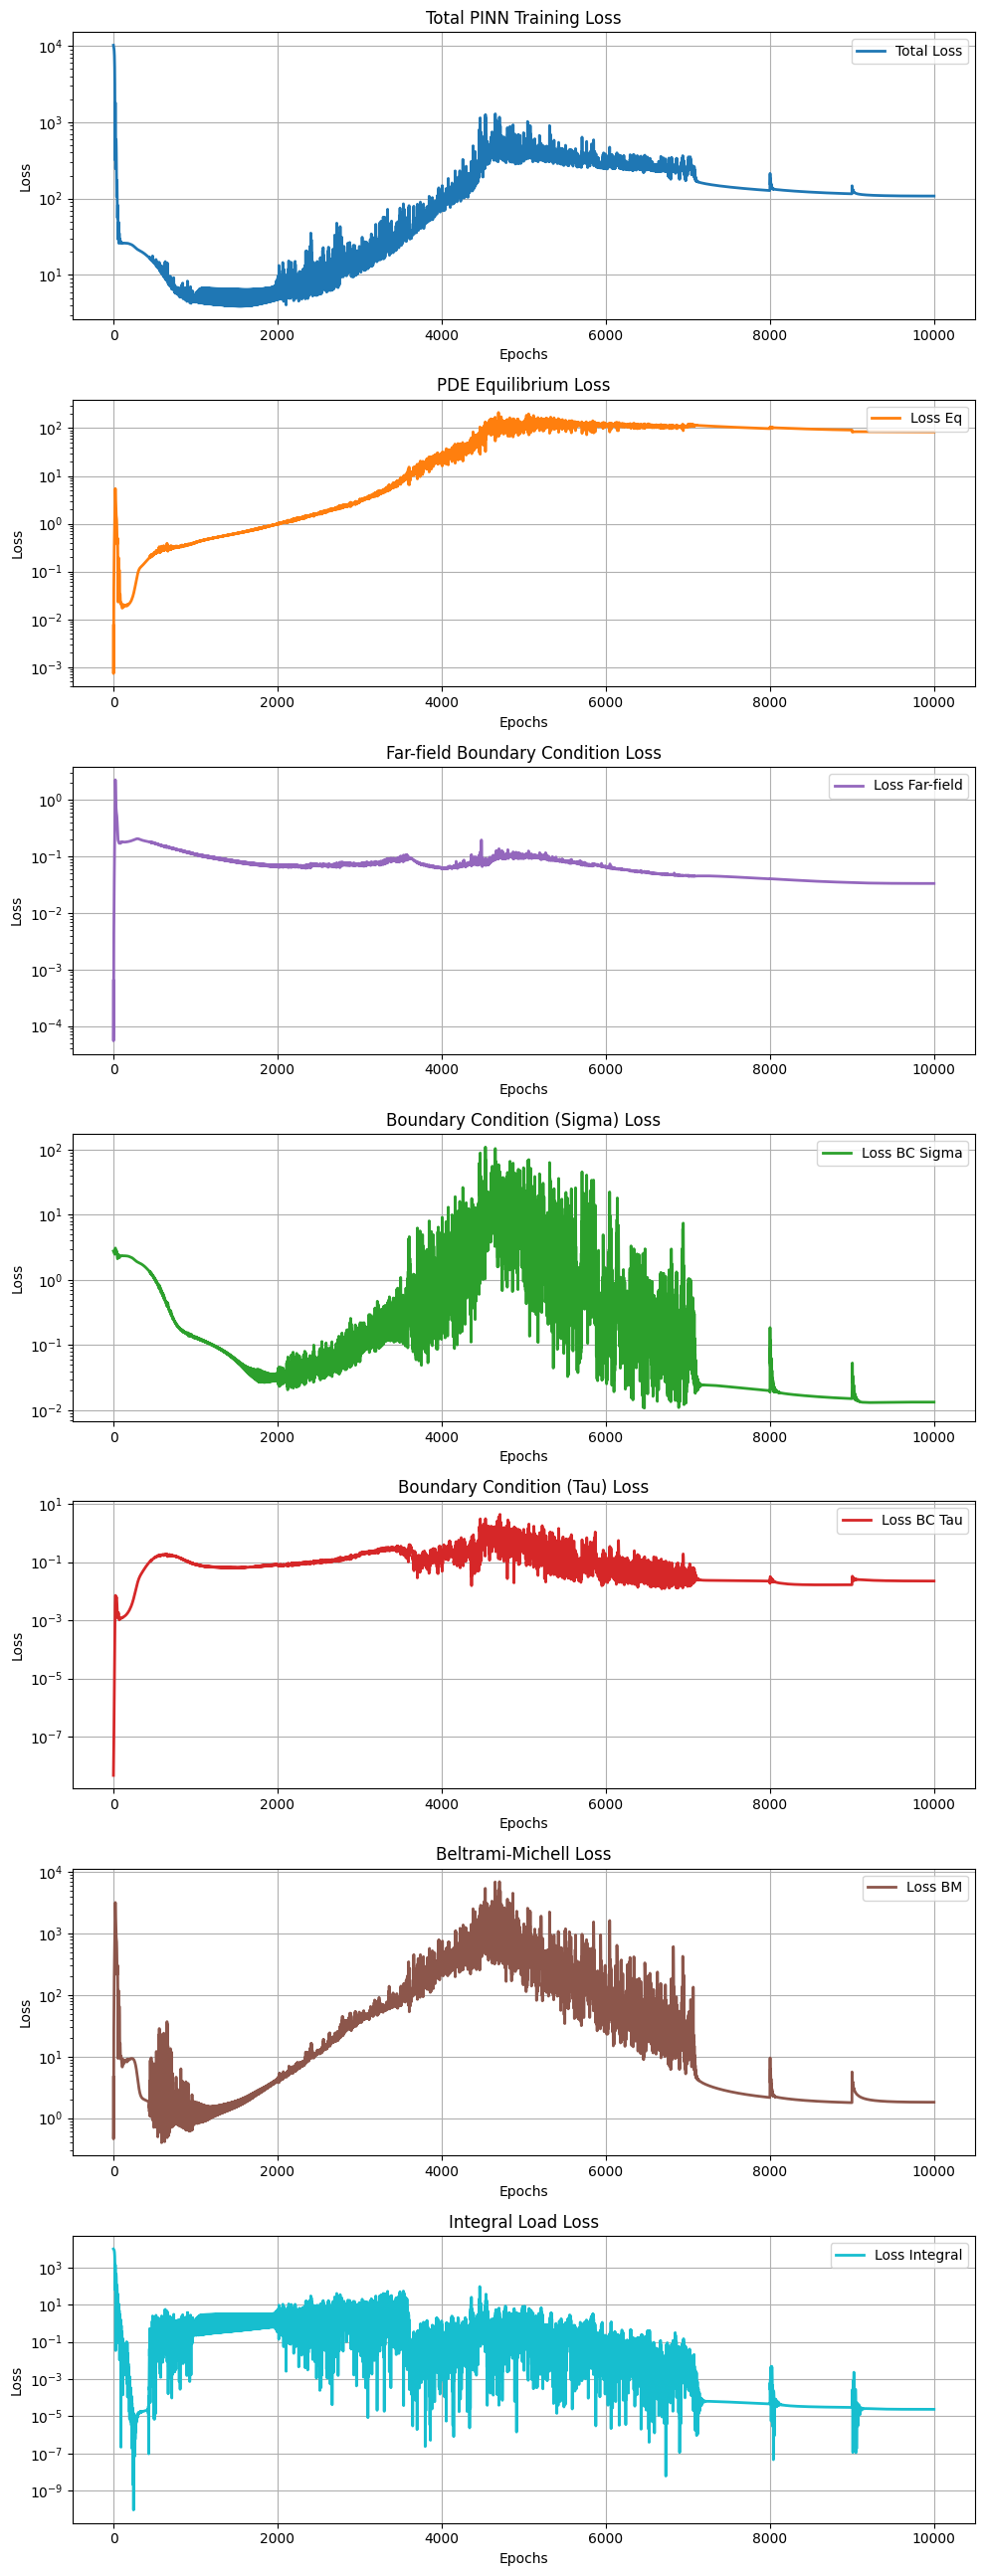

In [8]:
print("\n--- Plotting Learning Curves ---")

# Create 4 subplots in a single column (each in its own row)
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(10, 26))

# 1. Total Loss
axes[0].plot(solver.Total_loss, label='Total Loss', lw=2, color='tab:blue')
axes[0].set_yscale('log')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Total PINN Training Loss')
axes[0].grid(True)
axes[0].legend()

# 2. Equation Loss
axes[1].plot(solver.Loss_eq, label='Loss Eq', lw=2, color='tab:orange')
axes[1].set_yscale('log')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('PDE Equilibrium Loss')
axes[1].grid(True)
axes[1].legend()

#2. Far-field Loss
axes[2].plot(solver.Loss_far, label='Loss Far-field', lw=2, color='tab:purple')
axes[2].set_yscale('log')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Loss')
axes[2].set_title('Far-field Boundary Condition Loss')
axes[2].grid(True)
axes[2].legend()

# 3. BC Sigma Loss
axes[3].plot(solver.Loss_bc_sigma, label='Loss BC Sigma', lw=2, color='tab:green')
axes[3].set_yscale('log')
axes[3].set_xlabel('Epochs')
axes[3].set_ylabel('Loss')
axes[3].set_title('Boundary Condition (Sigma) Loss')
axes[3].grid(True)
axes[3].legend()

# 4. BC Tau Loss
axes[4].plot(solver.Loss_bc_tau, label='Loss BC Tau', lw=2, color='tab:red')
axes[4].set_yscale('log')
axes[4].set_xlabel('Epochs')
axes[4].set_ylabel('Loss')
axes[4].set_title('Boundary Condition (Tau) Loss')
axes[4].grid(True)
axes[4].legend()

# 5. BM Loss
axes[5].plot(solver.Loss_bm, label='Loss BM', lw=2, color='tab:brown')
axes[5].set_yscale('log')
axes[5].set_xlabel('Epochs')
axes[5].set_ylabel('Loss')
axes[5].set_title('Beltrami-Michell Loss')
axes[5].grid(True)
axes[5].legend()

# 6. Integral Loss
axes[6].plot(solver.Loss_int, label='Loss Integral', lw=2, color='tab:cyan')
axes[6].set_yscale('log')
axes[6].set_xlabel('Epochs')
axes[6].set_ylabel('Loss')
axes[6].set_title('Integral Load Loss')
axes[6].grid(True)
axes[6].legend()


# Adjust layout so titles and labels don't overlap
plt.tight_layout()
plt.show()

Masked Logarithmic Error (excluding r < 0.1): 34.9363%


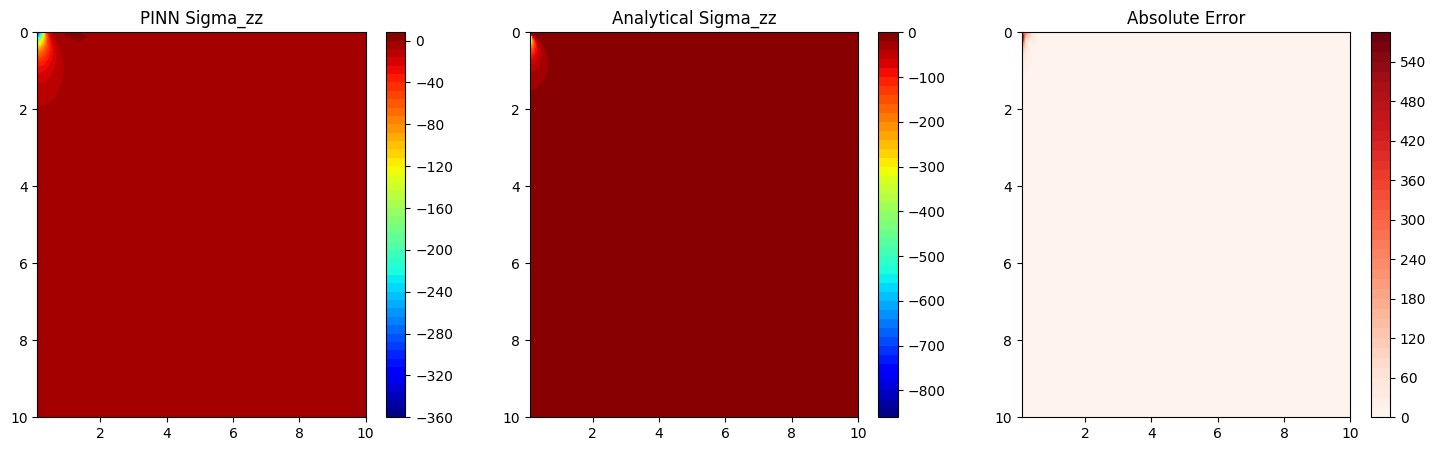

In [9]:
# --- Plotting ---
def plot_results():
    # Grid for plotting
    r = np.linspace(0.1, R_DOMAIN, 100)
    z = np.linspace(0.0, Z_DOMAIN, 100)
    R, Z = np.meshgrid(r, z)
    
    # Analytical Boussinesq (Sigma ZZ)
    # sigma_zz = - (3P / 2*pi) * (z^3 / rho^5)
    rho = np.sqrt(R**2 + Z**2)
    s_zz_analytical = - (3 * P_LOAD / (2 * np.pi)) * (Z**3 / rho**5)

    
    # PINN Prediction
    r_tens = torch.tensor(R.flatten(), dtype=torch.float32).unsqueeze(1).to(device)
    z_tens = torch.tensor(Z.flatten(), dtype=torch.float32).unsqueeze(1).to(device)
    
    s_zz_pred, _, _, _ = solver.get_stresses(r_tens, z_tens)
    s_zz_pred = s_zz_pred.cpu().detach().numpy().reshape(100, 100)
  
# ---------------------------------------------------------
# MASKED LOGARITHMIC ERROR CALCULATION
    # ---------------------------------------------------------
    # 1. Define the mask to exclude the singularity (r < 0.1)
    # You can use R > 0.1 or np.sqrt(R**2 + Z**2) > 0.1 depending on your preference
    epsilon = 0.1
    distance_from_load = np.sqrt(R**2 + Z**2)
    valid_mask = distance_from_load > epsilon  # Excludes the immediate load area
    
    # 2. Extract only the valid points
    pred_valid = s_zz_pred[valid_mask]
    exact_valid = s_zz_analytical[valid_mask]

    # 3. Calculate log10(1 + |x|) for the valid points
    log_pred = np.log10(1 + np.abs(pred_valid))
    log_exact = np.log10(1 + np.abs(exact_valid))

    # 4. Calculate the relative L2 norm in the logarithmic space
    if np.linalg.norm(log_exact) > 0:
        log_l2_error = np.linalg.norm(log_pred - log_exact) / np.linalg.norm(log_exact)
    else:
        log_l2_error = np.inf

    print(f"Masked Logarithmic Error (excluding r < {epsilon}): {log_l2_error:.4%}")
    # --

    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # PINN
    c1 = axes[0].contourf(R, Z, s_zz_pred, levels=50, cmap='jet')
    plt.colorbar(c1, ax=axes[0])
    axes[0].set_title("PINN Sigma_zz")
    axes[0].invert_yaxis()
    
    # Analytical
    c2 = axes[1].contourf(R, Z, s_zz_analytical, levels=50, cmap='jet')
    plt.colorbar(c2, ax=axes[1])
    axes[1].set_title("Analytical Sigma_zz")
    axes[1].invert_yaxis()
    
    # Error
    err = np.abs(s_zz_pred - s_zz_analytical)
    c3 = axes[2].contourf(R, Z, err, levels=50, cmap='Reds')
    plt.colorbar(c3, ax=axes[2])
    axes[2].set_title("Absolute Error")
    axes[2].invert_yaxis()
    
    plt.show()

    

plot_results()

In [10]:
def plot_1d_verification(solver, z_depth=2.0, r_limit=5.0):
    """
    Generates 1D stress profiles (Vertical and Radial) for verification 
    against the analytical Boussinesq solution.
    """
    solver.network.eval()
    
    # --- 1. Vertical Profile (Along r = 0.1 to avoid singularity) ---
    z_line = torch.linspace(0.1, solver.Z_DOMAIN, 500).view(-1, 1).to(device)
    r_const = torch.full_like(z_line, 0.1).to(device)
    
    # We must enable grads for get_stresses because it uses autograd.grad
    torch.set_grad_enabled(True) 
    s_zz_pinn, _, _, _ = solver.get_stresses(r_const, z_line)
    
    # Convert to numpy for plotting
    z_np = z_line.detach().cpu().numpy().flatten()
    r_np = r_const.detach().cpu().numpy().flatten()
    s_zz_pinn_np = s_zz_pinn.detach().cpu().numpy().flatten()
    
    # Analytical Vertical Stress (Boussinesq)
    R_dist = np.sqrt(r_np**2 + z_np**2)
    s_zz_analytical = -(3 * solver.P_load / (2 * np.pi)) * (z_np**3 / R_dist**5)

    # --- 2. Radial Profile (At Constant Depth z) ---
    r_line = torch.linspace(0.1, r_limit, 500).view(-1, 1).to(device)
    z_const = torch.full_like(r_line, z_depth).to(device)
    
    s_zz_radial_pinn, _, _, _ = solver.get_stresses(r_line, z_const)
    
    r_radial_np = r_line.detach().cpu().numpy().flatten()
    s_zz_radial_pinn_np = s_zz_radial_pinn.detach().cpu().numpy().flatten()
    
    # Analytical Radial Stress
    R_radial_dist = np.sqrt(r_radial_np**2 + z_depth**2)
    s_zz_radial_analytical = -(3 * solver.P_load / (2 * np.pi)) * (z_depth**3 / R_radial_dist**5)

    # --- Visualization ---
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Left Plot: Vertical Profile
    ax[0].plot(s_zz_pinn_np, z_np, 'r-', linewidth=2, label='PINN $\sigma_{zz}$')
    ax[0].plot(s_zz_analytical, z_np, 'k--', label='Analytical $\sigma_{zz}$')
    ax[0].set_title(f'Vertical Stress Profile (at r={r_np[0]})')
    ax[0].set_ylabel('Depth (z)')
    ax[0].set_xlabel('$\sigma_{zz}$')
    ax[0].invert_yaxis()
    ax[0].legend()
    ax[0].grid(True, which="both", ls="--")

    # Right Plot: Radial Profile
    ax[1].plot(r_radial_np, s_zz_radial_pinn_np, 'b-', linewidth=2, label='PINN $\sigma_{zz}$')
    ax[1].plot(r_radial_np, s_zz_radial_analytical, 'k--', label='Analytical $\sigma_{zz}$')
    ax[1].set_title(f'Radial Stress Profile (at z={z_depth})')
    ax[1].set_xlabel('Radial Distance (r)')
    ax[1].set_ylabel('$\sigma_{zz}$')
    ax[1].legend()
    ax[1].grid(True, which="both", ls="--")

    plt.tight_layout()
    plt.show()

<>:42: SyntaxWarning: invalid escape sequence '\s'
<>:43: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\s'
<>:52: SyntaxWarning: invalid escape sequence '\s'
<>:53: SyntaxWarning: invalid escape sequence '\s'
<>:56: SyntaxWarning: invalid escape sequence '\s'
<>:42: SyntaxWarning: invalid escape sequence '\s'
<>:43: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\s'
<>:52: SyntaxWarning: invalid escape sequence '\s'
<>:53: SyntaxWarning: invalid escape sequence '\s'
<>:56: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2590326386.py:42: SyntaxWarning: invalid escape sequence '\s'
  ax[0].plot(s_zz_pinn_np, z_np, 'r-', linewidth=2, label='PINN $\sigma_{zz}$')
/tmp/ipython-input-2590326386.py:43: SyntaxWarning: invalid escape sequence '\s'
  ax[0].plot(s_zz_analytical, z_np, 'k--', label='Analytical $\sigma_{zz}$')
/tmp/ipython-input-2590326386.py:46: SyntaxWarning: invalid escape se

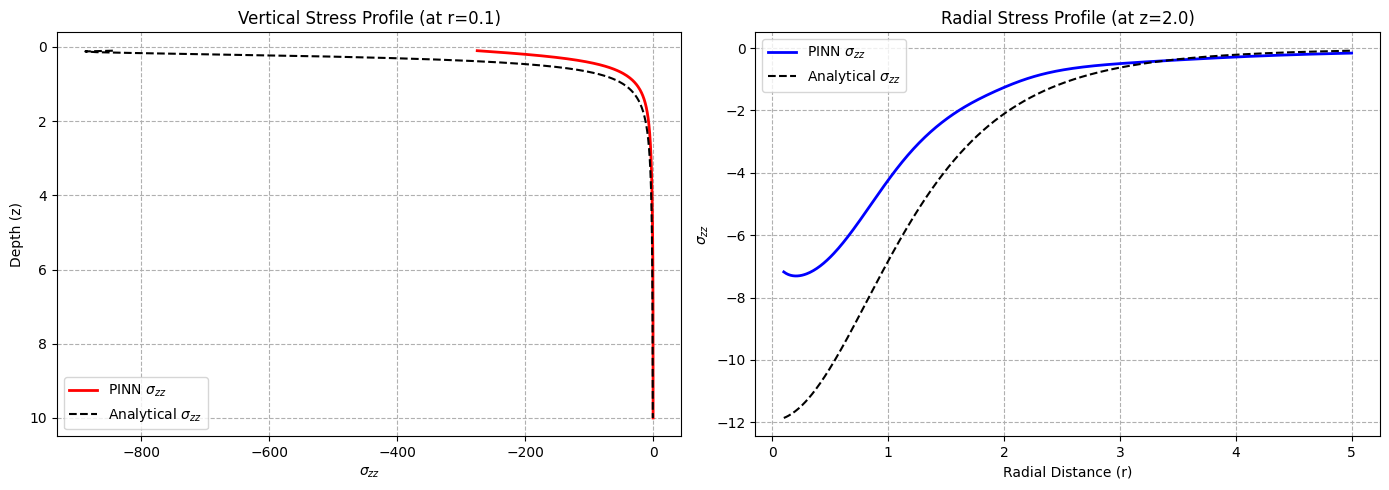

In [11]:
# Run verification at a depth of 2.0 units
plot_1d_verification(solver, z_depth=2.0, r_limit=R_DOMAIN/2)

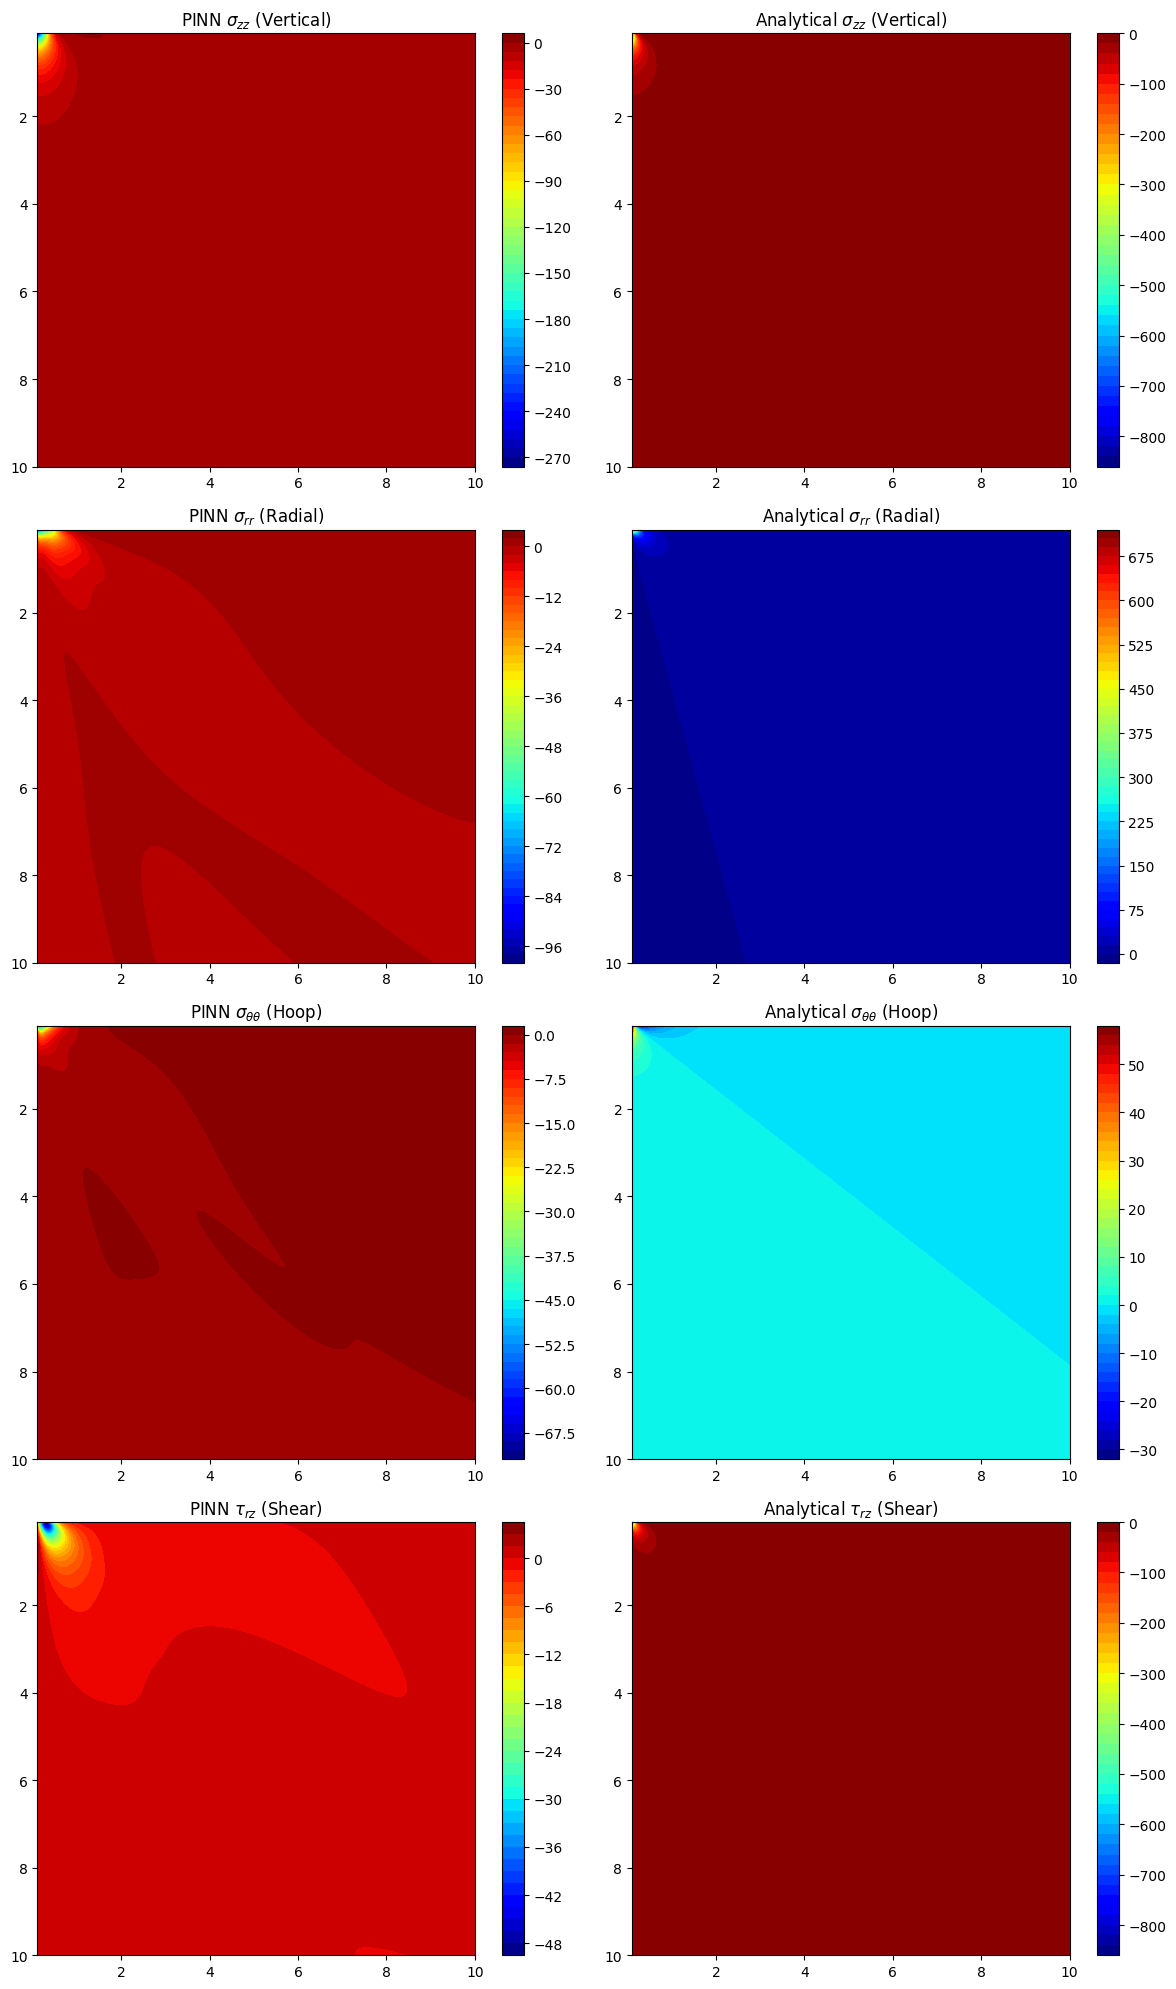

In [12]:
def plot_all_stresses(solver):
    solver.network.eval()
    
    # 1. Create a grid for evaluation
    r = np.linspace(0.1, R_DOMAIN, 200)
    z = np.linspace(0.1, Z_DOMAIN, 200)
    R, Z = np.meshgrid(r, z)
    
    r_tensor = torch.tensor(R.flatten(), dtype=torch.float64).view(-1, 1).to(device)
    z_tensor = torch.tensor(Z.flatten(), dtype=torch.float64).view(-1, 1).to(device)
    
    # 2. Get PINN Predictions
    torch.set_grad_enabled(True)
    s_zz_p, s_rr_p, s_tt_p, t_rz_p = solver.get_stresses(r_tensor, z_tensor)
    
    # Reshape results back to grid
    stresses_pinn = {
        'sigma_zz': s_zz_p.detach().cpu().numpy().reshape(R.shape),
        'sigma_rr': s_rr_p.detach().cpu().numpy().reshape(R.shape),
        'sigma_tt': s_tt_p.detach().cpu().numpy().reshape(R.shape),
        'tau_rz':   t_rz_p.detach().cpu().numpy().reshape(R.shape)
    }
    
    # 3. Compute Analytical Solutions
    rho = np.sqrt(R**2 + Z**2)
    P = solver.P_load
    nu = solver.nu
    
    # Standard Boussinesq formulas
    s_zz_a = -(3*P/(2*np.pi)) * (Z**3 / rho**5)
    
    # Radial stress
    term_rr = (1 - 2*nu) * (1/rho - 1/(rho + Z))
    s_rr_a = (P/(2*np.pi)) * ( (3 * R**2 * Z / rho**5) - term_rr / rho )
    
    # Hoop stress
    s_tt_a = (P*(1 - 2*nu)/(2*np.pi)) * ( (Z / rho**3) - (1 / (rho*(rho + Z))) )
    
    # Shear stress
    t_rz_a = -(3*P/(2*np.pi)) * (R * Z**2 / rho**5)
    
    analytical = {
        'sigma_zz': s_zz_a,
        'sigma_rr': s_rr_a,
        'sigma_tt': s_tt_a,
        'tau_rz':   t_rz_a
    }

    # 4. Plotting
    fig, axes = plt.subplots(4, 2, figsize=(12, 20))
    titles = [r'$\sigma_{zz}$ (Vertical)', r'$\sigma_{rr}$ (Radial)', 
              r'$\sigma_{\theta\theta}$ (Hoop)', r'$\tau_{rz}$ (Shear)']
    keys = ['sigma_zz', 'sigma_rr', 'sigma_tt', 'tau_rz']

    for i in range(4):
        # PINN Contour
        im1 = axes[i, 0].contourf(R, Z, stresses_pinn[keys[i]], levels=50, cmap='jet')
        axes[i, 0].set_title(f'PINN {titles[i]}')
        axes[i, 0].invert_yaxis()
        plt.colorbar(im1, ax=axes[i, 0])
        
        # Analytical Contour
        im2 = axes[i, 1].contourf(R, Z, analytical[keys[i]], levels=50, cmap='jet')
        axes[i, 1].set_title(f'Analytical {titles[i]}')
        axes[i, 1].invert_yaxis()
        plt.colorbar(im2, ax=axes[i, 1])

    plt.tight_layout()
    plt.show()

# Execute visualization
plot_all_stresses(solver)